In [37]:
# Enable auto-reloading of imports when they have been modified
from IPython import get_ipython
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os
import sys
import re
import random
import torch
import numpy as np
from pathlib import Path
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from captum.attr import visualization as viz

# Helper function to find the project root
def get_base_folder(project_root="PIPNet"):
    """Navigates up from the current directory to find the project root."""
    current_dir = Path.cwd()
    while True:
        if current_dir.name == project_root:
            return current_dir
        parent = current_dir.parent
        if parent == current_dir:
            raise RuntimeError(f"Project root '{project_root}' not found.")
        current_dir = parent

print("Libraries imported successfully.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Libraries imported successfully.


## Main config

In [73]:
# --- Class Name Mapping Function ---
def class_idx_to_name(idx: int) -> str:
    """
    Maps a class index (integer) to a human-readable class name (string).
    """
    class_map = {
        0: "1 Circle", 1: "1 Triangle", 2: "1 Hexagon",
        3: "2 Circles", 4: "2 Triangles", 5: "2 Hexagons",
        6: "3 Circles", 7: "3 Triangles", 8: "3 Hexagons",
    }
    return class_map.get(idx, f"Class {idx}")

# --- NEW: Prototype Label Mapping ---
prototype_labels = [
    {"prototype": 0, "label":  "Count-1"},
    {"prototype": 1, "label":  "Circ(3)"},
    {"prototype": 2, "label":  "Tri(2, 3)"},
    {"prototype": 3, "label":  "Count-1"},
    {"prototype": 4, "label":  "Circ(:)"},
    {"prototype": 5, "label":  "Dead"},
    {"prototype": 6, "label":  "Tri(1, 3)"},
    {"prototype": 7, "label":  "Hex(3)"},
    {"prototype": 8, "label":  "Circ(2)"},
    {"prototype": 9, "label":  "Hex(2, 3)"},
    {"prototype": 10, "label": "Hex(1)"},
    {"prototype": 11, "label": "Count-2"},
    {"prototype": 12, "label": "Circ(1, 2)"},
    {"prototype": 13, "label": "Hex(1, 2)"},
    {"prototype": 14, "label": "Count-1"},
    {"prototype": 15, "label":  "Dead"}
]
# Create a lookup dictionary for efficient access
PROTOTYPE_LABEL_MAP = {item['prototype']: item['label'] for item in prototype_labels}


# --- Main Configuration ---
try:
    PROJECT_ROOT = get_base_folder()
except RuntimeError as e:
    print(e)
    PROJECT_ROOT = Path('.') 

PROTOTYPE_MAPS_DIR = PROJECT_ROOT / 'data' / 'prototype_maps'
DATASET_NAME = 'geometric_shapes_no_noise'
DATASET_DIR = PROJECT_ROOT / 'data' / DATASET_NAME / 'dataset' / 'test'

# --- Analysis Parameters ---
ATTR_METHOD = 'ig' 
RANDOM_SEED = 21

# --- Output and Visualization Parameters ---
OUTPUT_DIR = PROJECT_ROOT / 'visualizations' / 'idg_interpretations' / 'individual_prototypes_all_classes'
os.makedirs(OUTPUT_DIR, exist_ok=True)

VIZ_CONFIG = {
    'percentile': 98,
    'alpha_overlay': 0.7,
    'num_cols': 3,
    'title_fontsize': 18,
    'w_space': 0.1,
    'h_space': 0.2,
    'save_dpi': 300,

    # --- Colormap Options ---
    # 'inferno' and 'hot' are good high-contrast options.
    'cmap': 'inferno',
    # Other high-contrast alternatives: 'hot', 'magma', 'afmhot', 'gist_heat'
}

random.seed(RANDOM_SEED)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Analyzing attribution method: '{ATTR_METHOD}'")

Project Root: C:\Edu\Mech_Interp\PIPNet
Output Directory: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes
Analyzing attribution method: 'ig'


In [74]:
from util.histograms import class_idx_to_name

def parse_filename(filename: Path, attr_method: str):
    """
    Parses a filename to extract prototype index, full image name, and class name.
    Example filename: "individual_prototype_4_class_1_img_0007_ig.pt"
    
    Args:
        filename (Path): The Path object for the file.
        attr_method (str): The attribution method string to match (e.g., 'ig').

    Returns:
        tuple: (prototype_index, image_name, class_name) or None if no match.
    """
    # This regex captures the prototype index, the full image name, and the class name
    pattern = re.compile(f"individual_prototype_(\\d+)_((class_\\d+)_img_\\d+)_{attr_method}\\.pt")
    match = pattern.match(filename.name)
    
    if match:
        proto_idx = int(match.group(1))
        img_name = match.group(2)  # e.g., "class_1_img_0007"
        class_name = match.group(3) # e.g., "class_1"
        return proto_idx, img_name, class_name
    return None

def load_original_image(class_name: str, img_name: str) -> np.ndarray:
    """
    Loads the original image and converts it to a NumPy array scaled to [0, 1].
    
    Args:
        class_name (str): The class directory name (e.g., "class_1").
        img_name (str): The base name of the image (e.g., "class_1_img_0007").
        
    Returns:
        np.ndarray: The image as a numpy array with shape (H, W, C) and values in [0, 1].
    """
    # The image name in the dataset folder does not contain the class prefix
    # e.g., "class_1_img_0007" -> "img_0007.png"
    base_img_name = "_".join(img_name.split('_')[2:])
    img_path = DATASET_DIR / class_name / f"{base_img_name}.png"
    
    if not img_path.exists():
        print(f"Warning: Image not found at {img_path}")
        return np.zeros((224, 224, 3)) # Return a black image as a fallback

    with Image.open(img_path).convert('RGB') as img:
        return np.array(img) / 255.0

print("Helper functions defined.")

Helper functions defined.


## Main loop

Scanning for prototype maps...
Found data for 14 unique prototypes using method 'ig'.

--- Processing Prototype 0 ---
  Found maps for 3 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_0_summary_ig.png


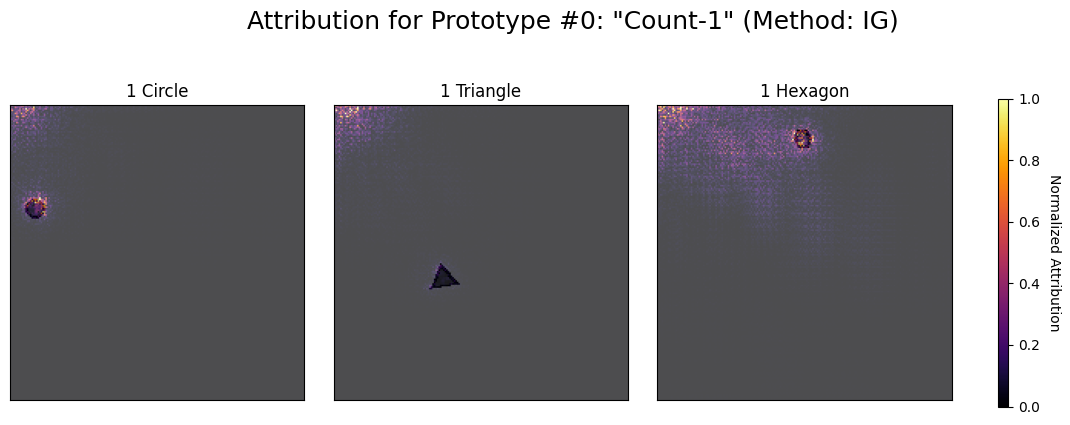


--- Processing Prototype 1 ---
  Found maps for 1 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_1_summary_ig.png


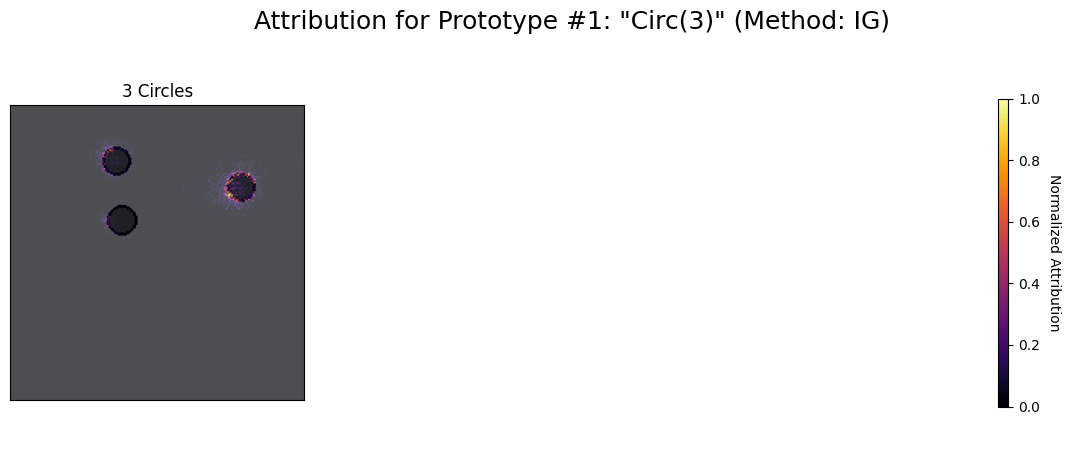


--- Processing Prototype 2 ---
  Found maps for 2 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_2_summary_ig.png


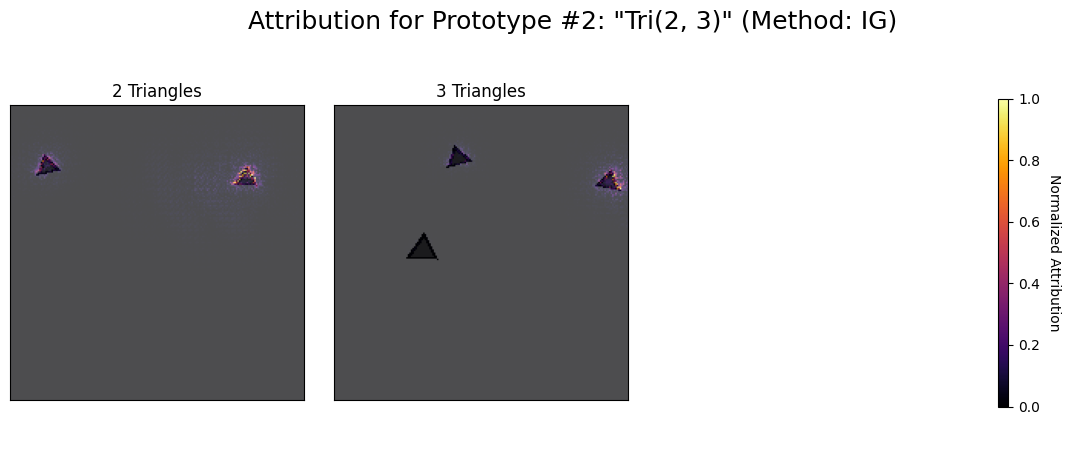


--- Processing Prototype 3 ---
  Found maps for 3 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\miniforge3\envs\mi_aisc\Lib\site-pack

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_3_summary_ig.png


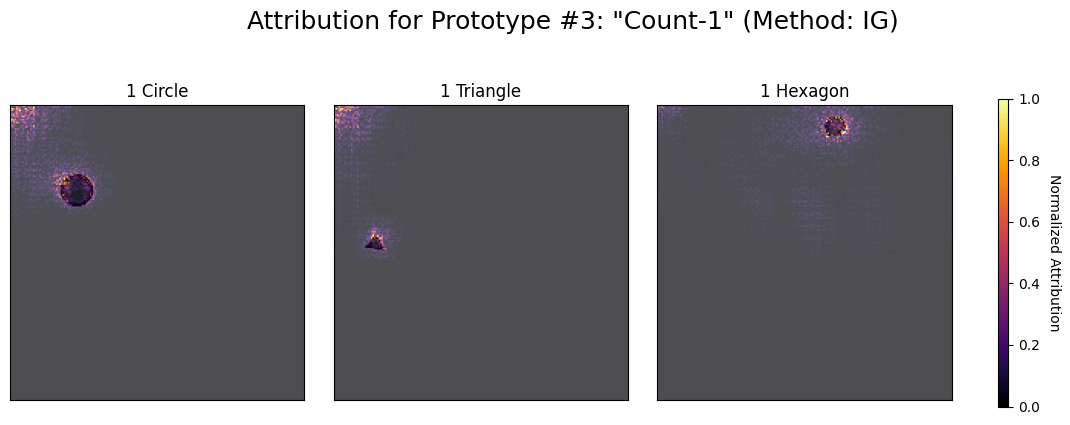


--- Processing Prototype 4 ---
  Found maps for 3 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_4_summary_ig.png


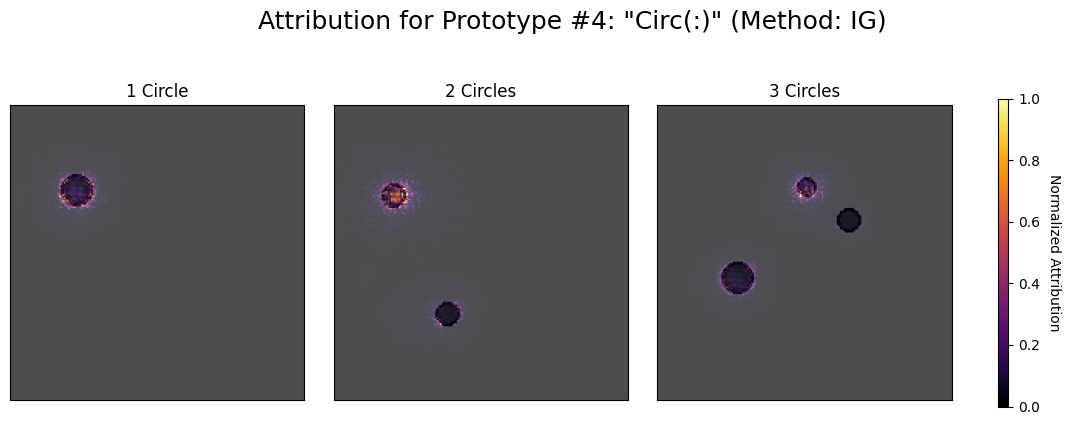


--- Processing Prototype 6 ---
  Found maps for 2 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_6_summary_ig.png


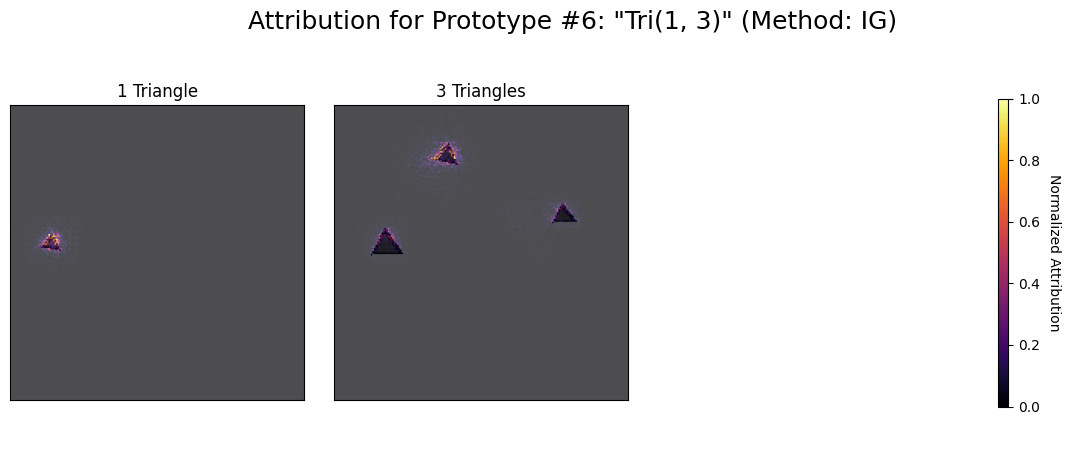


--- Processing Prototype 7 ---
  Found maps for 1 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_7_summary_ig.png


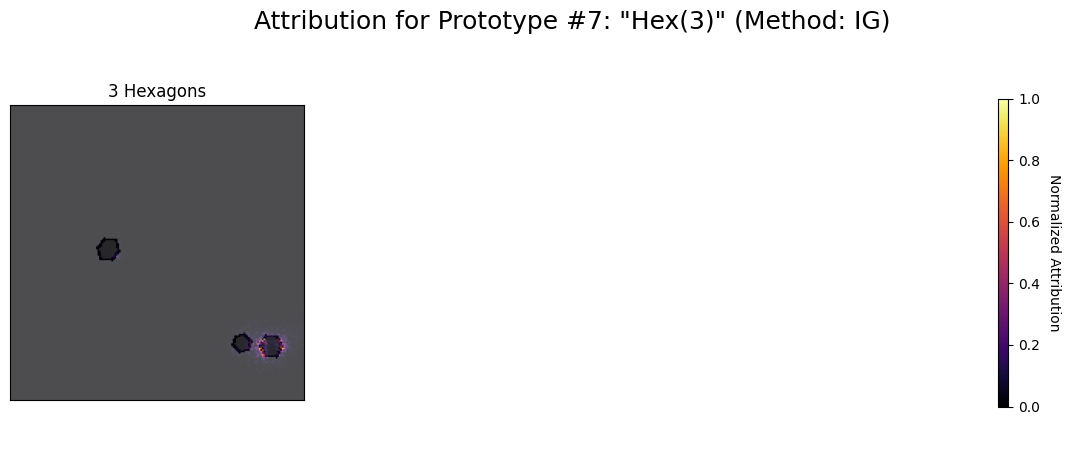


--- Processing Prototype 8 ---
  Found maps for 1 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_8_summary_ig.png


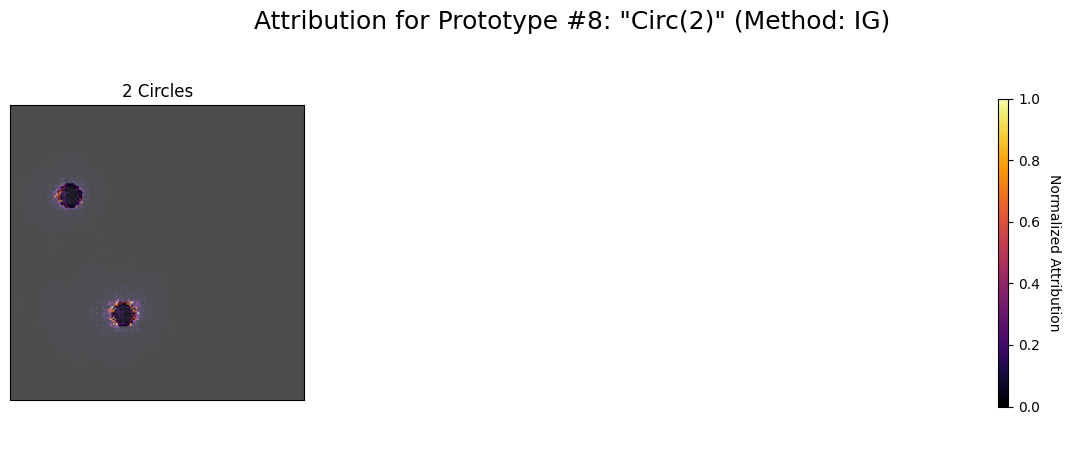


--- Processing Prototype 9 ---
  Found maps for 2 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_9_summary_ig.png


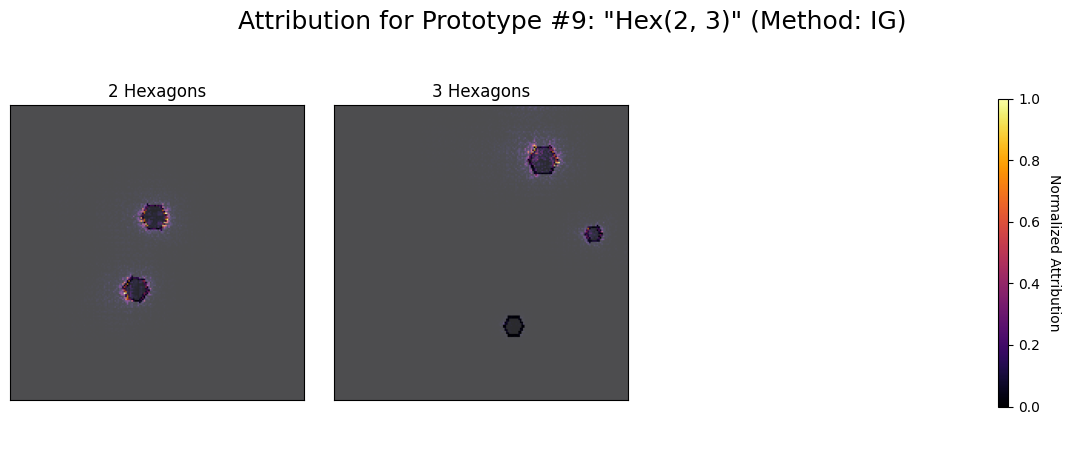


--- Processing Prototype 10 ---
  Found maps for 1 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_10_summary_ig.png


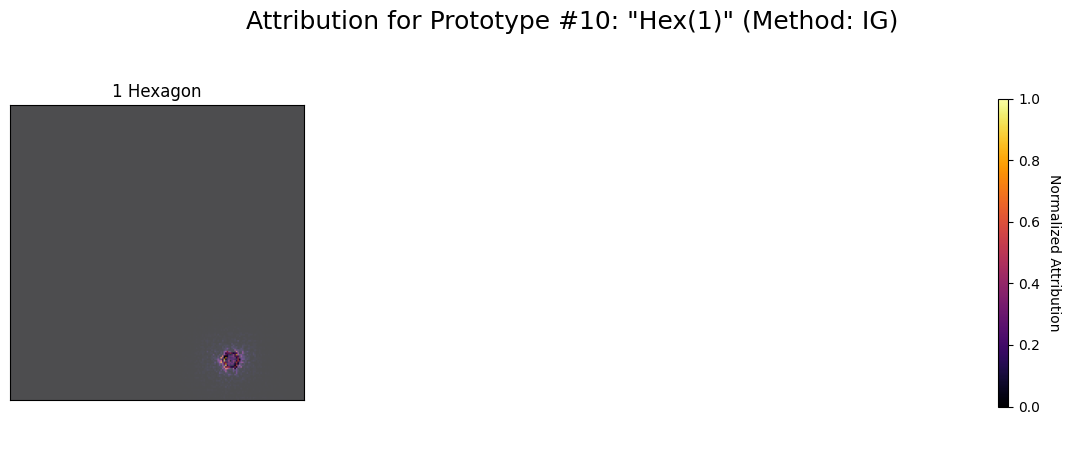


--- Processing Prototype 11 ---
  Found maps for 3 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_11_summary_ig.png


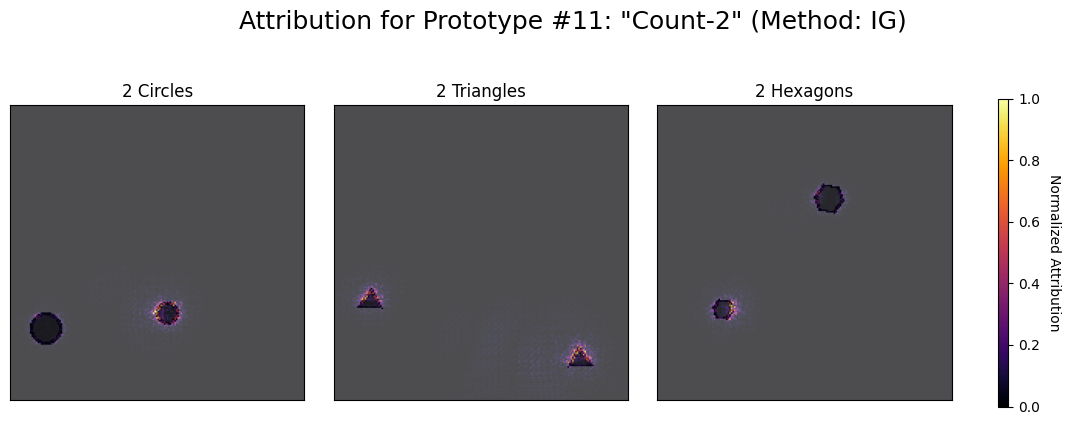


--- Processing Prototype 12 ---
  Found maps for 2 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_12_summary_ig.png


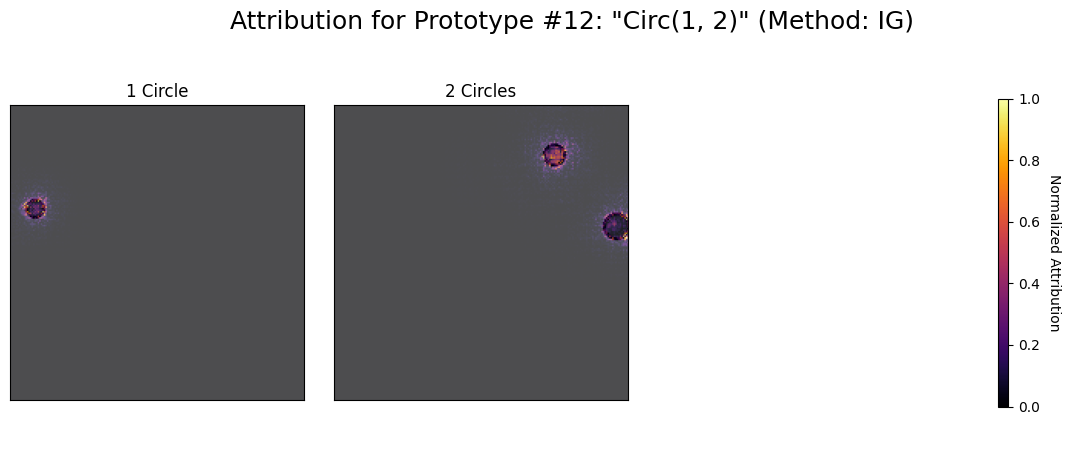


--- Processing Prototype 13 ---
  Found maps for 2 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_13_summary_ig.png


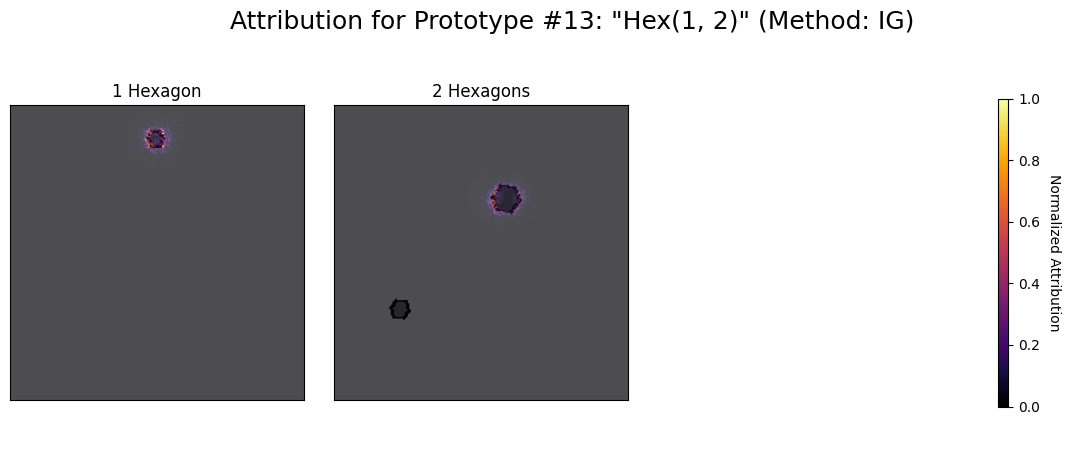


--- Processing Prototype 14 ---
  Found maps for 3 unique classes. Sampling and plotting.


C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\889213679.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_39240\88

  Saved figure to: C:\Edu\Mech_Interp\PIPNet\visualizations\idg_interpretations\individual_prototypes_all_classes\prototype_14_summary_ig.png


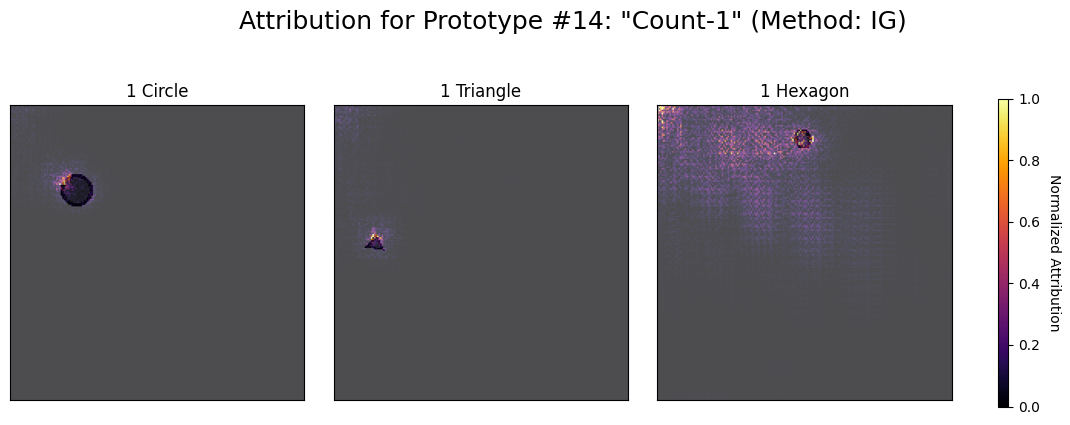


--- Analysis Complete ---


In [75]:
# 1. Group all available attribution maps by prototype and class
print("Scanning for prototype maps...")
prototypes_data = defaultdict(lambda: defaultdict(list))

for file_path in PROTOTYPE_MAPS_DIR.glob(f"*.pt"):
    parsed_info = parse_filename(file_path, ATTR_METHOD)
    if parsed_info:
        proto_idx, img_name, class_name = parsed_info
        prototypes_data[proto_idx][class_name].append({
            'path': file_path,
            'img_name': img_name
        })

print(f"Found data for {len(prototypes_data)} unique prototypes using method '{ATTR_METHOD}'.")

# 2. Iterate over each prototype, sample, and plot
for proto_idx, class_files_dict in sorted(prototypes_data.items()):
    print(f"\n--- Processing Prototype {proto_idx} ---")
    
    num_classes_found = len(class_files_dict)
    if num_classes_found == 0:
        continue

    print(f"  Found maps for {num_classes_found} unique classes. Sampling and plotting.")

    # 3. Sample maps and calculate grid dimensions
    selected_maps_info = [
        {'class_name': class_name, **random.choice(files)}
        for class_name, files in sorted(class_files_dict.items())
    ]
    
    num_plots = len(selected_maps_info)
    num_cols = VIZ_CONFIG['num_cols']
    num_rows = (num_plots + num_cols - 1) // num_cols 

    # 4. Create the visualization grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5), squeeze=False)
    axes = axes.flatten()

    for i, map_info in enumerate(selected_maps_info):
        ax = axes[i]
        attr_map_np = torch.load(map_info['path'])
        original_image = load_original_image(map_info['class_name'], map_info['img_name'])

        class_idx = int(map_info['class_name'].split('_')[-1]) - 1
        human_readable_name = class_idx_to_name(class_idx)

        viz.visualize_image_attr(
            attr=attr_map_np,
            original_image=original_image,
            method='blended_heat_map',
            sign='absolute_value',
            cmap=VIZ_CONFIG['cmap'],
            outlier_perc=100 - VIZ_CONFIG['percentile'],
            plt_fig_axis=(fig, ax),
            show_colorbar=False,
            title=human_readable_name,
            alpha_overlay=VIZ_CONFIG['alpha_overlay'],
            use_pyplot=False
        )

    # 5. Hide unused subplots
    for i in range(num_plots, len(axes)):
        axes[i].axis('off')
        
    # 6. Apply main title and adjust layout
    # --- MODIFICATION: Use prototype label map and capitalize method name ---
    prototype_display_name = PROTOTYPE_LABEL_MAP.get(proto_idx, f"Prototype {proto_idx}")
    title_text = (
        f"Attribution for Prototype #{proto_idx}: \"{prototype_display_name}\" "
        f"(Method: {ATTR_METHOD.upper()})"
    )
    
    fig.suptitle(
        title_text, 
        fontsize=VIZ_CONFIG['title_fontsize'], 
        y=0.98
    )
    fig.subplots_adjust(
        wspace=VIZ_CONFIG['w_space'], 
        hspace=VIZ_CONFIG['h_space']
    )
    
    # 7. Add a single, shared colorbar
    if num_plots > 0:
        norm = colors.Normalize(vmin=0, vmax=1)
        sm = cm.ScalarMappable(cmap=VIZ_CONFIG['cmap'], norm=norm)
        cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.8, aspect=30, pad=0.04)
        cbar.set_label('Normalized Attribution', rotation=270, labelpad=15)

    # 8. Save the figure
    save_filename = f"prototype_{proto_idx}_summary_{ATTR_METHOD}.png"
    save_path = OUTPUT_DIR / save_filename
    fig.savefig(save_path, dpi=VIZ_CONFIG['save_dpi'], bbox_inches='tight')
    print(f"  Saved figure to: {save_path}")

    plt.show()
    plt.close(fig)

print("\n--- Analysis Complete ---")